<img src="http://www.comunicacionsocial.uam.mx/identidaduam/images/variacion6.jpg" alt="MDN" style="width: 200px;"/>

    

# **Representación de la Actividad Magnética Cerebral**
## **Jair Zamorano García**

La actividad cerebral hace referencia al parpadeo constante de corrientes y transmisiones eléctricas del cerebro. Esta actividad neuronal es la responsable de todo lo que hacemos, sentimos y pensamos. 


MNE es una librería de Python que procesa y visualiza datos producida por diferentes dispositivos. En este caso vamos a mapear cierto registro de ondas cerebrales capturadas por una magnetoencefalografía, la cual es una prueba que mide los campos magnéticos producidos por las corrientes eléctricas del cerebro, derivado a la activación neuronal. 

### **Nota: recuerde que debe instalar todas las librerías utilizadas, en caso de que no pueda, le dejo un video del funcionamiento del jupyter. Todas las librerias las instale usando pip.**

<img src="https://mne.tools/stable/_images/mne_logo.svg" alt="MDN" style="width: 200px;"/>

## Importación de librerías

In [2]:
import numpy as np
import matplotlib
import mne 
mne.set_log_level('WARNING')
import bqplot.pyplot as plt
import ipywidgets
from ipywidgets import VBox
from bqplot import ColorScale
from pythreejs import *
from IPython.display import display
from mne.datasets import spm_face
from pythreejs import *
from IPython.display import display

MNE tiene diversas herramientas, una de ellas es que podemos descargar archivos y guardarlos en la raíz del almacenamiento creando una ruta especifica para encontrar el archivo. Se descargan los datos de una base de datos de la misma librería que nos proporciona (https://osf.io/je4s8/download?version=2.). La descarga de archivos es aproximadamente de 2 GB, por lo tanto, si es la primera ocasión ejecutando este programa, tendrá que esperar a que se descargue el archivo. Finalmente podemos eliminar el numeral en la ultima línea de código para descubrir la ruta donde se ha guardado el archivo.

In [3]:
data_path = spm_face.data_path()
raw_fname = data_path + '/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds'
#print(raw_fname)

Debido a que el archivo descargado contiene datos extra, como matrices, figuras 3D etc., del estudio realizado, los vamos a eliminar mediante un filtro, dejando solo los datos de lectura de los campos magnéticos producidos por las neuronas.

In [4]:
raw = mne.io.read_raw_ctf(raw_fname, preload = True)
print(raw)
raw.filter(1., 40., fir_design='firwin')

<RawCTF | SPM_CTF_MEG_example_faces1_3D.meg4, 340 x 324474 (676.0 s), ~842.2 MB, data loaded>


<RawCTF | SPM_CTF_MEG_example_faces1_3D.meg4, 340 x 324474 (676.0 s), ~842.2 MB, data loaded>

In [6]:
events = mne.find_events(raw, stim_channel='UPPT001', verbose = True)

172 events found
Event IDs: [1 2 3]


A partir de la siguiente celda, haremos el uso de la clase “epochs”, propia de MNE, para definir las instancias así como propiedades y poder hacer la primer grafica de la actividad del campo magnético. 
#### Mas info. aqui (https://mne.tools/stable/generated/mne.Epochs.html)


In [7]:
event_id = {"faces": 1,"scrambled": 2}
tmin, tmax = -0.1,0.5

picks = mne.pick_types(raw.info, meg=True, stim=True, eog=True, ref_meg= True, exclude='bads')

decim = 2
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True, reject=dict(mag=1.5e-12),decim=decim)
print(epochs)

<Epochs |  167 events (all good), -0.1 - 0.5 sec, baseline off, ~56.9 MB, data loaded,
 'faces': 84
 'scrambled': 83>


## Actividad capturada por los magnetómetros en diversos intervalos de tiempo

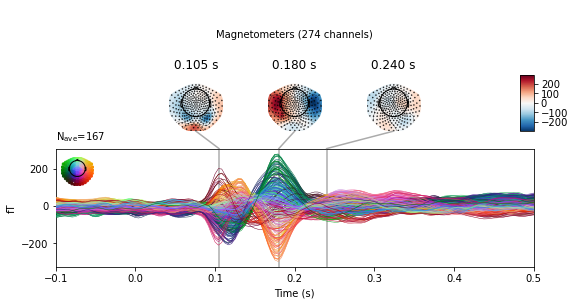

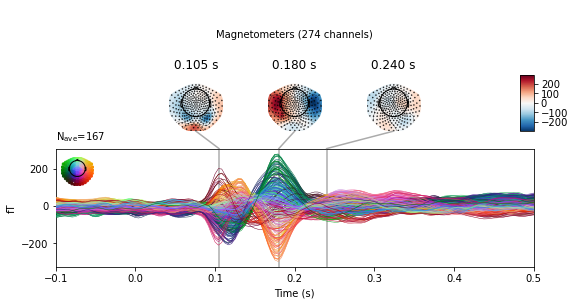

In [8]:
evoked = epochs.average()
evoked.plot_joint(times=[0.105, 0.180, 0.240])

In [9]:
data = epochs.get_data()
data_mean = np.mean(data, axis=0)[31:]

#### **Para poder manipular la grafica, utilizaremos matplotlib, entonces necesitamos asignar los colores de las ondas magnéticas, lo haremos utilizando CSS debido a la compatibilidad de jupyter con HTML5**

In [10]:
#utilidades colores
def _rgb(x, y,z):
    
    rgb = np.array([x,y,z]).T
    rgb -= rgb.min(0)
    rgb /= rgb.max(0)
    return rgb

def rgb_to_css(rgb):
    for color in rgb:
        if color > 1 or color < 0:
            raise ValueError('Los valores rgb deben estar entre 0 y 1, se proporcionó un valor de rgb ({}) que no es valido'.format(rgb))
    hexes = ["%02X" % int(color*255) for color in rgb]
    return ''.join(['#']+hexes)

def color_scale(data, colors):
    n_colors = len(colors)
    mi, ma = data.min(), data.max()
    def f(x):
        index = int(n_colors * (x-mi)/(ma - mi))
        return colors[index - 1]
    return f

def diverging_color_scale(data, colors):
    mi, ma = data.min(), data.max()
    def f(x):
        if x < 0:
            t = (mi - x)/mi
            t = np.clip(t, 0, 1)
            return (1-t) * colors[0] + t * colors[1]
        else:
            t = (ma - x)/ma
            t = np.clip(t, 0, 1)
            return (1-t) * colors[2] + t * colors[1]
    return f


In [11]:
chs = evoked.info['chs']
locs3d = np.array([ch['loc'][:3] for ch in chs])[31:]
x, y, z = locs3d.T
colors = _rgb(x, y, z)
colors = [rgb_to_css(c)for c in colors]

## **Figura del cerebro en 2D**

In [12]:
fig2 = plt.figure(min_aspect_ratio=1, max_aspect_ratio=1, title='Vista superior',
                 layout = {'min_width': '600px', 'min_height': '600px'})
sc_c = ColorScale(colors=['orangered','black','deepskyblue'], min = data_mean.min()*1e15, max = data_mean.max()*1.5e15)
scat = plt.scatter(x,y, colors = colors, scales = {'color':sc_c}, axes_options={'x': {'visible':False}, 'y': {'visible':False}})

## Representacion de la grafica en un intervalo de tiempo con la figura 2D con colores actualizados, mueva el cursor sobre la grafica para actualizar

In [13]:
def update_colors(name,value):
    sel = l.selected
    if len(sel)== 0:
        return
    scat.color = data_mean[:, sel[0]]*1e15
    fig2.title = 'Captura en t = {:.1f} ms'.format(value[0])
    
fig = plt.figure(title = 'Señal Magnetoencefalografíca', layout={'min_width': '800px'})

l = plt.plot(1e3*epochs.times,1e15*data_mean,stroke_width=.2,iterpolation='cardinal',
            colors=colors, axes_options={'x':{'label':'Tiempo (ms)'},
                                        'y':{'label':'Campo Magnetico(fT)'}})
index_sel = plt.index_selector(update_colors)
plt.vline(0, line_style='dashed')
VBox([fig,fig2])

## Desarrollo de la figura en 3D usando MeshLambertMaterial, eliminar el numeral para obtener la figura simple en 3D

In [14]:
sensors = [Mesh(geometry=SphereGeometry(radius=0.003),material=MeshLambertMaterial(color=colors[i]),
               position=[x[i],y[i],z[i]])
          for i in range(len(x))]
scene = Scene(children=sensors+ [AmbientLight(color='white')])

c = PerspectiveCamera(position=[0,1,1], up=[0,0,2],)
renderer = Renderer(camera=c,
                   scene=scene, controls=[OrbitControls(controlling=c)])
#display(renderer)

In [15]:
red, black, blue = np.array([255,69,0])/255, np.array([.2,.2,.2]), np.array([0,191,255])/255
col_sc= diverging_color_scale(data_mean,[red,black,blue])
precomputed_colors = np.array([[rgb_to_css(col_sc(d))for d in di] for di in data_mean])

def actualizar_colors_3d(change):
    sel = l.selected
    if len(sel)== 0:
        return
    for i,b in enumerate(sensors):
        b.material.color = precomputed_colors[i, sel[0]]
        
        
fig = plt.figure(title = 'Señal Magnetoencefalografíca', layout={'min_width': '800px'})
l = plt.plot(1e3*epochs.times,1e15*data_mean,stroke_width=.2,iterpolation='cardinal',
            colors=colors, axes_options={'x':{'label':'Tiempo (ms)'},
                                        'y':{'label':'Campo Magnetico(fT)'}})
plt.index_selector(actualizar_colors_3d)
plt.vline(0, line_style='dashed')

VBox([fig,renderer])